# Temporal consistency of preterm dysmaturation - macroscale
## Extent and location of IBAPs
Despite tremendous heterogeneity in brain aberrations after preterm birth, we found some commonalities between subjects. Therefore, we show in this notebook that:
1. The extent of the IBAPs (i.e., number of extranormal regions within a subject) scales with gestational age
2. The locations of the IBAPs are consistent along individual development

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import join
import pandas as pd
import numpy as np

from statsmodels.stats.multitest import fdrcorrection

import gc

# plot settings
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rc_file('code/matplotlibrc')

# import custom functions
import sys
sys.path.append('code')
from plotting import correlation_plot, plot_percentage_outside_norm_groups
from utils import get_roi_names
from longitudinal import *

# directories
centile_dir = 'outputs/spatial_heterogeneity'
outputs_dir = 'outputs/consistency_macroscale'
os.makedirs(outputs_dir, exist_ok=True)


color_pt = 'darkorange'

In [3]:
# load all necessary data, i.e., deviation scores computed in script 1
try:
    # Q1: extent of IBAPs
    bls_26_ct = pd.read_csv(join(centile_dir, 'BLS-26/IBAP_CT/BLS-26_CT_centiles_per_subject.csv'), index_col=0)
    dhcp_ct = pd.read_csv(join(centile_dir, 'dHCP/IBAP_CT/dHCP_CT_centiles_per_subject.csv'), index_col=0)
    abcd_ct = pd.read_csv(join(centile_dir, 'ABCD-10/IBAP_CT/ABCD-10_CT_centiles_per_subject.csv'))  # contains both sessions
    #abcd_ct = abcd_ct.set_index(['participant', 'session'])
    
    # Q2: locations of IBAPs
    dhcp_sa = pd.read_csv(join(centile_dir, 'dHCP/IBAP_SA/dHCP_SA_centiles_per_subject.csv'))
    
    bls_26_sa = pd.read_csv(join(centile_dir, 'BLS-26/IBAP_SA/BLS-26_SA_centiles_per_subject.csv'))
    bls_26_sa = bls_26_sa.set_index(['participant', 'session'])
    
    bls_38_sa = pd.read_csv(join(centile_dir, 'BLS-38/IBAP_SA/BLS-38_SA_centiles_per_subject.csv'))
    bls_38_sa['session'] = 2
    bls_38_sa = bls_38_sa.set_index(['participant', 'session'])
    
    abcd_sa = pd.read_csv(join(centile_dir, 'ABCD-10/IBAP_SA/ABCD-10_SA_centiles_per_subject.csv'))  # contains both sessions
    abcd_sa = abcd_sa.set_index(['participant', 'session'])
    
    # supplement
    bls_38_ct = pd.read_csv(join(centile_dir, 'BLS-38/IBAP_CT/BLS-38_CT_centiles_per_subject.csv'))
    bls_38_ct['session'] = 2
    bls_38_ct = bls_38_ct.set_index(['participant', 'session'])
    
    
except FileNotFoundError:
    print('Run script 1 for all required modalities and datasets first: BLS-26 CT, BLS-26 SA, BLS-38 SA, dHCP CT, ABCD-10 SA')
    sys.exit()

# 1. The extent of the IBAPs scales with gestational age

### Number of extranormal regions is correlated with gestational age

In [4]:
out_dir = join(outputs_dir, 'extent')
os.makedirs(out_dir, exist_ok=True)

# restore plot settings
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rc_file('code/matplotlibrc')

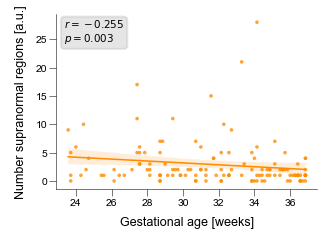

In [5]:
# dHCP CT
dhcp_ct_termeq = dhcp_ct[dhcp_ct['scan'] == 'term_equivalent']

x = 'GA'
y = 'amount_supranormal'
outname = join(out_dir, f'dHCP_CT_preterm_correlation_{x}_{y}.svg')

# filter for preterms
dhcp_ct_termeq_pt = dhcp_ct_termeq[dhcp_ct_termeq['dx'] == 'preterm']

correlation_plot(x, y, data=dhcp_ct_termeq_pt, color=color_pt, 
                xlabel='Gestational age [weeks]', ylabel='Number supranormal regions [a.u.]', outname=outname)


ABCD-10 CT: 5953 subjects


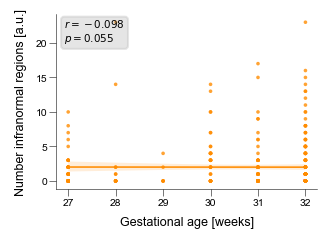

In [6]:
# ABCD-10 CT
abcd_ct_10 = abcd_ct[abcd_ct['session'] == 1]
print(f'ABCD-10 CT: {len(abcd_ct_10)} subjects')

x = 'GA'
y = 'amount_infranormal'
outname = join(out_dir, f'ABCD-10_CT_preterm_correlation_{x}_{y}.svg')

# filter for preterms
abcd_ct_pt = abcd_ct[abcd_ct['dx'] == 'preterm']

correlation_plot(x, y, data=abcd_ct_pt, color=color_pt, 
                xlabel='Gestational age [weeks]', ylabel='Number infranormal regions [a.u.]', outname=outname)

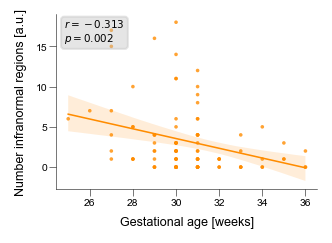

In [7]:
# BLS-26 CT
x = 'GA'
y = 'amount_infranormal'
outname = join(out_dir, f'BLS-26_CT_preterm_correlation_{x}_{y}.svg')

# filter for preterms
bls_26_ct_pt = bls_26_ct[bls_26_ct['dx'] == 'preterm']

correlation_plot(x, y, data=bls_26_ct_pt, color=color_pt, 
                xlabel='Gestational age [weeks]', ylabel='Number infranormal regions [a.u.]', outname=outname)

In [8]:
# FDR correction
_, p_fdr = fdrcorrection(pvals=[0.003, 0.055, 0.002], alpha=0.05, method='indep')
print(f'FDR-corrected p-values: {p_fdr}')

FDR-corrected p-values: [0.0045 0.055  0.0045]


### Number of extranormal deviations scales with gestational age
#### Main analysis
Separate preterm subjects into two groups, those born before 30 weeks and those born after 30 weeks. By this means, group sizes are more or less balanced. Then, compute the number of extranormal regions in each subject and plot the results.

In [9]:
# get roi names
rois_cortical = get_roi_names('CT', bilateral=True, global_vars=False)

--- dHCP CT ---
Born before 30 weeks: n = 45
Born between 30 and 36 weeks: n = 86


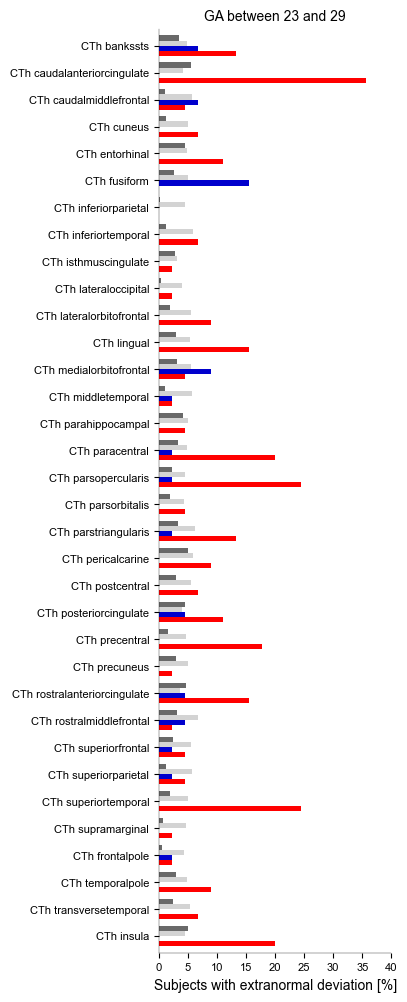

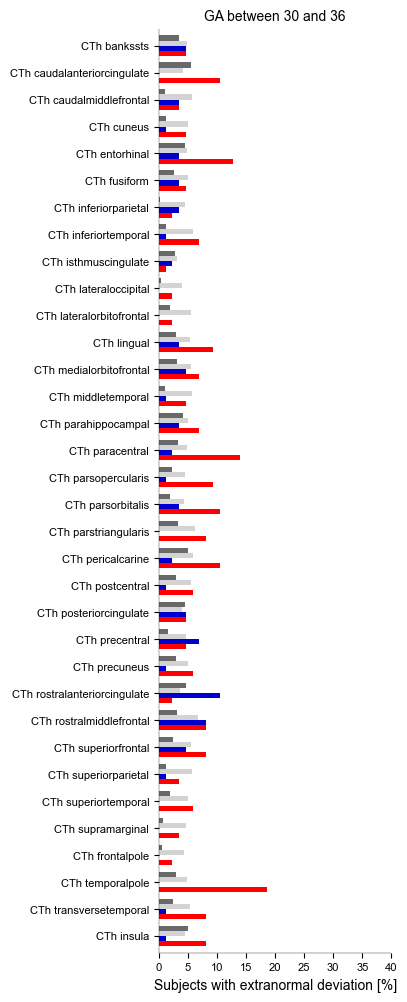

Up to 36% of preterm subjects born before 30 weeks gestational age share a supranormal region in the same location
Up to 19% of preterm subjects born after 30 weeks gestational age share a supranormal region in the same location


In [10]:
# group dHCP preterm subjects into earlier and later birth
print('--- dHCP CT ---')
cent_scores_pt_before30 = dhcp_ct_termeq_pt[(dhcp_ct_termeq_pt['GA'] <= 30)]
print("Born before 30 weeks: n =", cent_scores_pt_before30.shape[0])

cent_scores_pt_after30 = dhcp_ct_termeq_pt[(dhcp_ct_termeq_pt['GA'] > 30) & (dhcp_ct_termeq_pt['GA'] < 37)]
print("Born between 30 and 36 weeks: n =", cent_scores_pt_after30.shape[0])

dhcp_ct_ft = dhcp_ct[dhcp_ct['dx'] == 'CN']


# before 30 weeks
age_thr_lower = int(cent_scores_pt_before30['GA'].min())
age_thr_upper = int(cent_scores_pt_before30['GA'].max())
# age_thr_upper = 30
outname = join(out_dir, f'dHCP_individual_percentage_outside_norm_GA{age_thr_lower}_{age_thr_upper}.svg')
infra_supra_before = plot_percentage_outside_norm_groups(rois_cortical, dhcp_ct_ft, cent_scores_pt_before30, age_thr_lower, age_thr_upper, outname, xlims=(0,40))

# after 30 weeks
age_thr_lower = int(cent_scores_pt_after30['GA'].min())
age_thr_upper = int(cent_scores_pt_after30['GA'].max())
outname = join(out_dir, f'dHCP_individual_percentage_outside_norm_GA{age_thr_lower}_{age_thr_upper}.svg')
infra_supra_after = plot_percentage_outside_norm_groups(rois_cortical, dhcp_ct_ft, cent_scores_pt_after30, age_thr_lower, age_thr_upper, outname,xlims=(0,40))


# extranormal percentages
print(f'Up to {infra_supra_before.supranormal_pt.max():.0f}% of preterm subjects born before 30 weeks gestational age share a supranormal region in the same location')
print(f'Up to {infra_supra_after.supranormal_pt.max():.0f}% of preterm subjects born after 30 weeks gestational age share a supranormal region in the same location')

--- BLS-26 CT ---
Born before 30 weeks: 53
Born between 30 and 36 weeks: 43


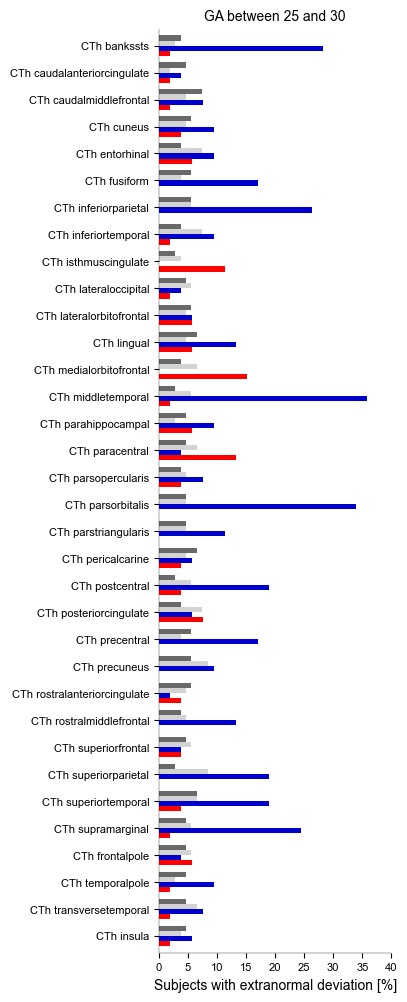

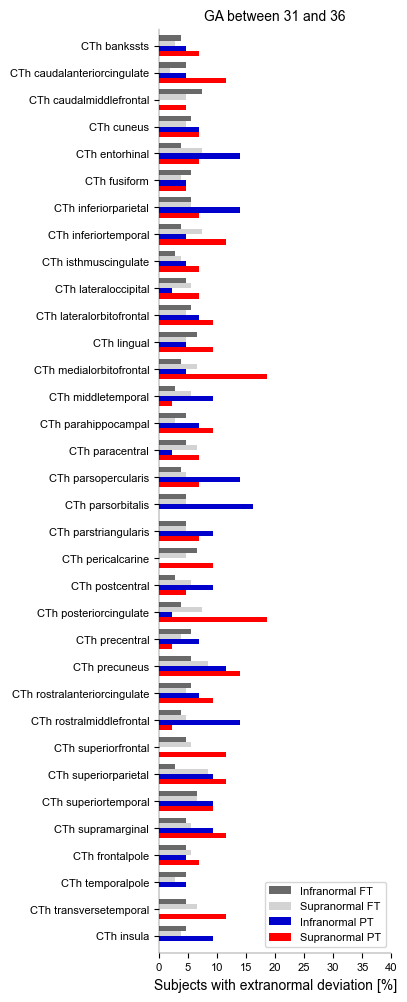

Up to 36% of preterm subjects born before 30 weeks gestational age share an infranormal region in the same location
Up to 16% of preterm subjects born after 30 weeks gestational age share an infranormal region in the same location


In [11]:
# group BLS-26 preterm subjects into earlier and later birth
print('--- BLS-26 CT ---')
cent_scores_pt_before30 = bls_26_ct_pt[(bls_26_ct_pt['GA'] <= 30)]
print("Born before 30 weeks:", cent_scores_pt_before30.shape[0])

cent_scores_pt_after30 = bls_26_ct_pt[(bls_26_ct_pt['GA'] > 30) & (bls_26_ct_pt['GA'] < 37)]
print("Born between 30 and 36 weeks:", cent_scores_pt_after30.shape[0])

bls_26_ct_ft = bls_26_ct[bls_26_ct['dx'] == 'CN']


# before 30 weeks
age_thr_lower = int(cent_scores_pt_before30['GA'].min())
age_thr_upper = int(cent_scores_pt_before30['GA'].max())
outname = join(out_dir, f'BLS-26_individual_percentage_outside_norm_GA{age_thr_lower}_{age_thr_upper}.svg')
infra_supra_before = plot_percentage_outside_norm_groups(rois_cortical, bls_26_ct_ft, cent_scores_pt_before30, age_thr_lower, age_thr_upper, outname, xlims=(0, 40))

# after 30 weeks
age_thr_lower = (cent_scores_pt_after30['GA'].min())
age_thr_upper = int(cent_scores_pt_after30['GA'].max())
outname = join(out_dir, f'BLS-26_individual_percentage_outside_norm_GA{age_thr_lower}_{age_thr_upper}.svg')
infra_supra_after = plot_percentage_outside_norm_groups(rois_cortical, bls_26_ct_ft, cent_scores_pt_after30, age_thr_lower, age_thr_upper, outname, add_legend=True, xlims=(0, 40))

# extranormal percentages
print(f'Up to {infra_supra_before.infranormal_pt.max():.0f}% of preterm subjects born before 30 weeks gestational age share an infranormal region in the same location')
print(f'Up to {infra_supra_after.infranormal_pt.max():.0f}% of preterm subjects born after 30 weeks gestational age share an infranormal region in the same location')

#### Supplementary analysis
Use the same approach as above, but instead of separating preterm subjects into three groups following a separation that is more clinically used: 
- =< 28 weeks: extreme preterm
- 28 < GA < 32 weeks: very preterm
- => 32 weeks: moderate preterm

--- dHCP CT ---
Born before 28 weeks: n = 25
Born between 28 and 32 weeks: n = 37
Born between 32 and 37 weeks: n = 69


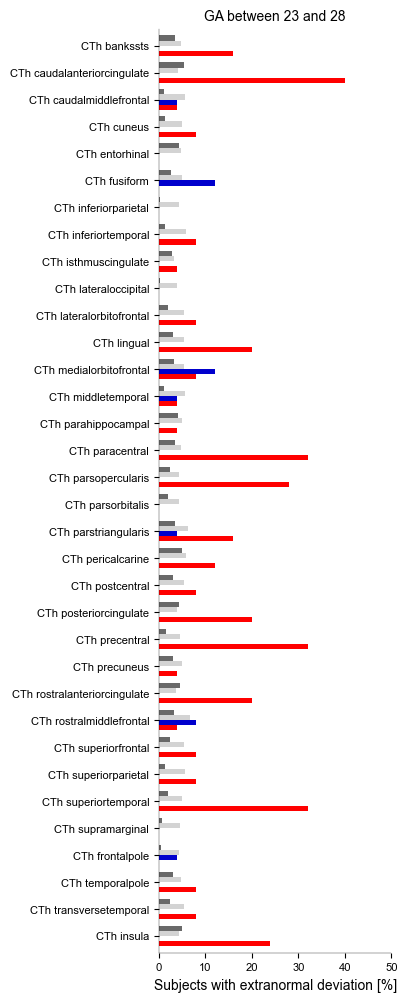

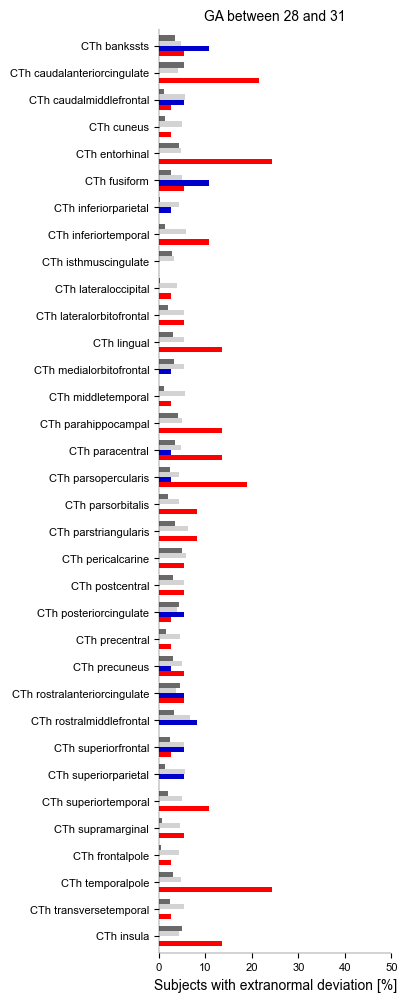

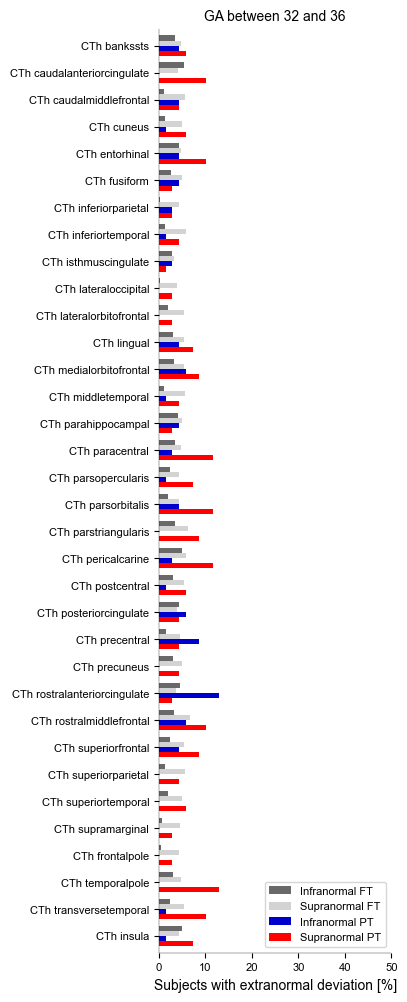

Up to 40% of preterm subjects born before 28 weeks gestational age share a supranormal region in the same location
Up to 24% of preterm subjects born between 28 and 32 weeks gestational age share a supranormal region in the same location
Up to 13% of preterm subjects born after 32 weeks gestational age share a supranormal region in the same location


In [12]:
# group dHCP preterm subjects into earlier and later birth
print('--- dHCP CT ---')
cent_scores_pt_before28 = dhcp_ct_termeq_pt[(dhcp_ct_termeq_pt['GA'] <= 28)]
print("Born before 28 weeks: n =", cent_scores_pt_before28.shape[0])

cent_scores_pt_28_to_32 = dhcp_ct_termeq_pt[(dhcp_ct_termeq_pt['GA'] > 28) & (dhcp_ct_termeq_pt['GA'] <= 32)]
print("Born between 28 and 32 weeks: n =", cent_scores_pt_28_to_32.shape[0])

cent_scores_pt_after32 = dhcp_ct_termeq_pt[(dhcp_ct_termeq_pt['GA'] > 32) & (dhcp_ct_termeq_pt['GA'] < 37)]
print("Born between 32 and 37 weeks: n =", cent_scores_pt_after32.shape[0])

dhcp_ct_ft = dhcp_ct[dhcp_ct['dx'] == 'CN']


# before 28 weeks
age_thr_lower = int(cent_scores_pt_before28['GA'].min())
age_thr_upper = int(cent_scores_pt_before28['GA'].max())
outname = join(out_dir, f'dHCP_individual_percentage_outside_norm_GA{age_thr_lower}_{age_thr_upper}.svg')
infra_supra_before28 = plot_percentage_outside_norm_groups(rois_cortical, dhcp_ct_ft, cent_scores_pt_before28, age_thr_lower, age_thr_upper, outname, xlims=(0, 50))

# between 28 and 32 weeks
age_thr_lower = int(cent_scores_pt_28_to_32['GA'].min())
age_thr_upper = int(cent_scores_pt_28_to_32['GA'].max())
outname = join(out_dir, f'dHCP_individual_percentage_outside_norm_GA{age_thr_lower}_{age_thr_upper}.svg')
infra_supra_between28_and_32 = plot_percentage_outside_norm_groups(rois_cortical, dhcp_ct_ft, cent_scores_pt_28_to_32, age_thr_lower, age_thr_upper, outname, xlims=(0, 50))

# after 32 weeks
age_thr_lower = int(cent_scores_pt_after32['GA'].min())
age_thr_upper = int(cent_scores_pt_after32['GA'].max())
outname = join(out_dir, f'dHCP_individual_percentage_outside_norm_GA{age_thr_lower}_{age_thr_upper}.svg')
infra_supra_after_32 = plot_percentage_outside_norm_groups(rois_cortical, dhcp_ct_ft, cent_scores_pt_after32, age_thr_lower, age_thr_upper, outname, xlims=(0, 50), add_legend=True)

# extranormal percentages
print(f'Up to {infra_supra_before28.supranormal_pt.max():.0f}% of preterm subjects born before 28 weeks gestational age share a supranormal region in the same location')
print(f'Up to {infra_supra_between28_and_32.supranormal_pt.max():.0f}% of preterm subjects born between 28 and 32 weeks gestational age share a supranormal region in the same location')
print(f'Up to {infra_supra_after_32.supranormal_pt.max():.0f}% of preterm subjects born after 32 weeks gestational age share a supranormal region in the same location')

--- BLS-26 CT ---
Born before 28 weeks: n = 14
Born between 28 and 32 weeks: n = 67
Born between 32 and 37 weeks: n = 15


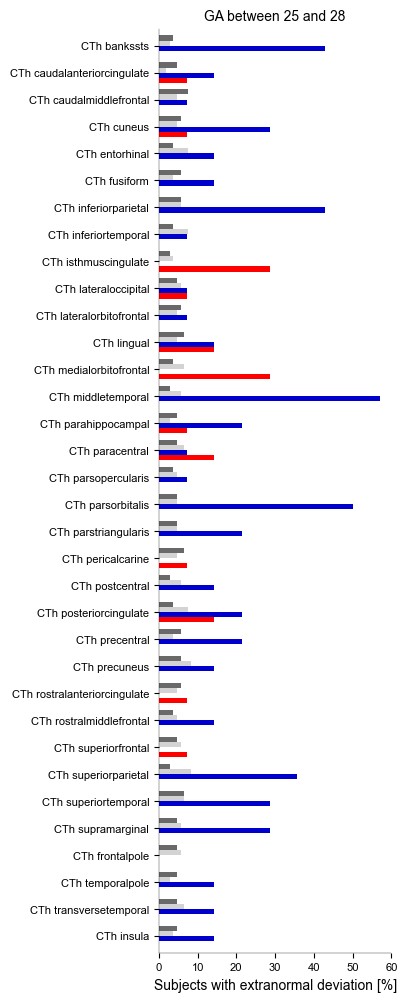

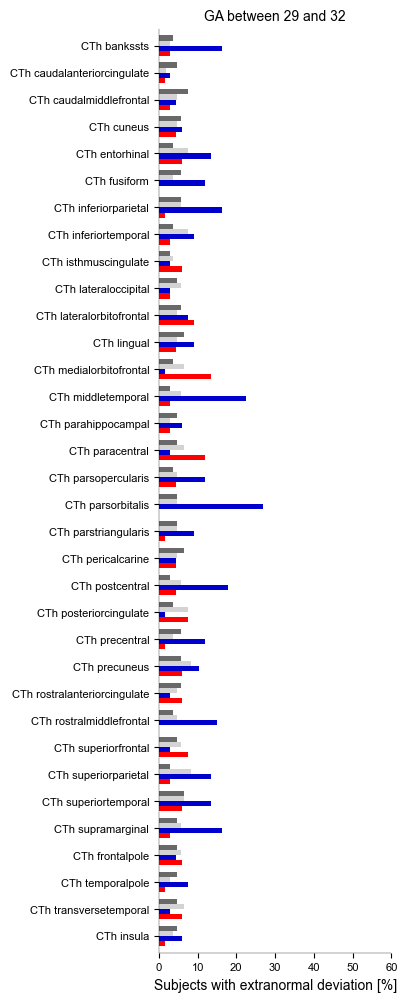

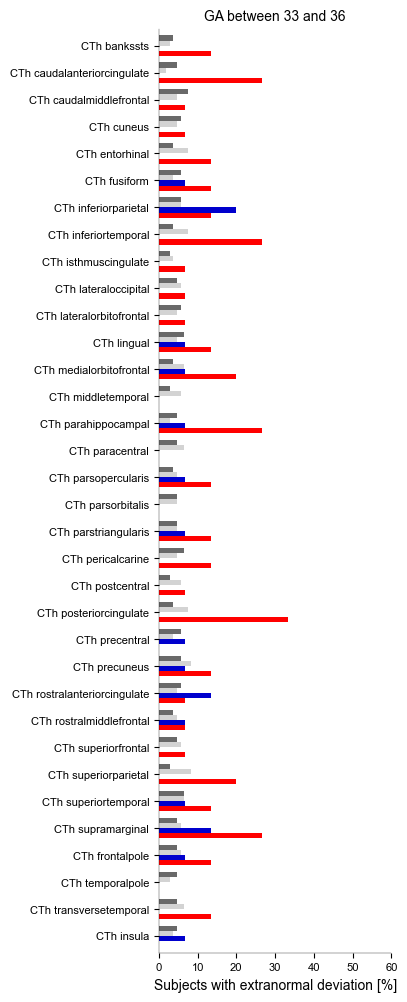

Up to 57% of preterm subjects born before 28 weeks gestational age share an infranormal region in the same location
Up to 27% of preterm subjects born between 28 and 32 weeks gestational age share an infranormal region in the same location
Up to 20% of preterm subjects born after 32 weeks gestational age share an infranormal region in the same location


In [13]:
# group BLS-26 preterm subjects into earlier and later birth
print('--- BLS-26 CT ---')
cent_scores_pt_before28 = bls_26_ct_pt[(bls_26_ct_pt['GA'] <= 28)]
print("Born before 28 weeks: n =", cent_scores_pt_before28.shape[0])

cent_scores_pt_28_to_32 = bls_26_ct_pt[(bls_26_ct_pt['GA'] > 28) & (bls_26_ct_pt['GA'] <= 32)]
print("Born between 28 and 32 weeks: n =", cent_scores_pt_28_to_32.shape[0])

cent_scores_pt_after32 = bls_26_ct_pt[(bls_26_ct_pt['GA'] > 32) & (bls_26_ct_pt['GA'] < 37)]
print("Born between 32 and 37 weeks: n =", cent_scores_pt_after32.shape[0])

bls_26_ct_ft = bls_26_ct[bls_26_ct['dx'] == 'CN']


# before 28 weeks
age_thr_lower = int(cent_scores_pt_before28['GA'].min())
age_thr_upper = int(cent_scores_pt_before28['GA'].max())
outname = join(out_dir, f'BLS-26_individual_percentage_outside_norm_GA{age_thr_lower}_{age_thr_upper}.svg')
infra_supra_before28 = plot_percentage_outside_norm_groups(rois_cortical, bls_26_ct_ft, cent_scores_pt_before28, age_thr_lower, age_thr_upper, outname)

# between 28 and 32 weeks
age_thr_lower = int(cent_scores_pt_28_to_32['GA'].min())
age_thr_upper = int(cent_scores_pt_28_to_32['GA'].max())
outname = join(out_dir, f'BLS-26_individual_percentage_outside_norm_GA{age_thr_lower}_{age_thr_upper}.svg')
infra_supra_between28_and_32 = plot_percentage_outside_norm_groups(rois_cortical, bls_26_ct_ft, cent_scores_pt_28_to_32, age_thr_lower, age_thr_upper, outname)

# after 32 weeks
age_thr_lower = int(cent_scores_pt_after32['GA'].min())
age_thr_upper = int(cent_scores_pt_after32['GA'].max())
outname = join(out_dir, f'BLS-26_individual_percentage_outside_norm_GA{age_thr_lower}_{age_thr_upper}.svg')
infra_supra_after_32 = plot_percentage_outside_norm_groups(rois_cortical, bls_26_ct_ft, cent_scores_pt_after32, age_thr_lower, age_thr_upper, outname)

# extranormal percentages
print(f'Up to {infra_supra_before28.infranormal_pt.max():.0f}% of preterm subjects born before 28 weeks gestational age share an infranormal region in the same location')
print(f'Up to {infra_supra_between28_and_32.infranormal_pt.max():.0f}% of preterm subjects born between 28 and 32 weeks gestational age share an infranormal region in the same location')
print(f'Up to {infra_supra_after_32.infranormal_pt.max():.0f}% of preterm subjects born after 32 weeks gestational age share an infranormal region in the same location')

## Supplementary analysis: association of amount of infranormal regions with severity of prematurity

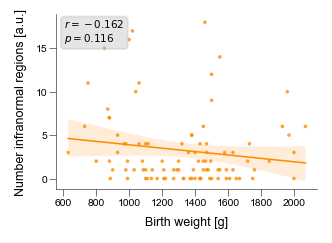

In [14]:
# BLS-26 CT - BW
x = 'BW'
y = 'amount_infranormal'
outname = join(out_dir, f'BLS-26_CT_preterm_correlation_{x}_{y}.svg')

correlation_plot(x, y, data=bls_26_ct_pt, color=color_pt, 
                xlabel='Birth weight [g]', ylabel='Number infranormal regions [a.u.]', outname=outname)

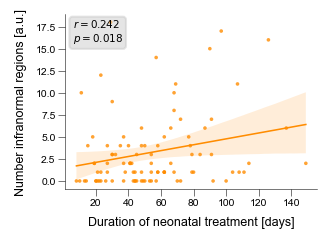

In [15]:
# BLS-26 CT - DNTI
x = 'dnti'
y = 'amount_infranormal'
outname = join(out_dir, f'BLS-26_CT_preterm_correlation_{x}_{y}.svg')

correlation_plot(x, y, data=bls_26_ct_pt, color=color_pt, 
                xlabel='Duration of neonatal treatment [days]', ylabel='Number infranormal regions [a.u.]', outname=outname)

In [16]:
# FDR correction
_, p_fdr = fdrcorrection(pvals=[0.116, 0.018], alpha=0.05, method='indep')
print(f'FDR-corrected p-values: {p_fdr}')

FDR-corrected p-values: [0.116 0.036]


# 2. The locations of the IBAPs are consistent along individual development

In [17]:
out_dir = join(outputs_dir, 'location')
os.makedirs(out_dir, exist_ok=True)

rois_cortical = get_roi_names('SA', bilateral=True, global_vars=False)
rois_cortical_centiles = ['centile_' + roi for roi in rois_cortical]

rois_main = ['centile_SA_caudalanteriorcingulate', 'centile_SA_fusiform', 'centile_SA_inferiorparietal', 
                'centile_SA_inferiortemporal', 'centile_SA_isthmuscingulate']

## Child development - ABCD

/var/folders/tk/3rqd03yd6rqb4_przznzwzjc0000gn/T/ipykernel_63492/2790823195.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abcd_sa_pt.rename(columns={'session': 'timepoint'}, inplace=True)


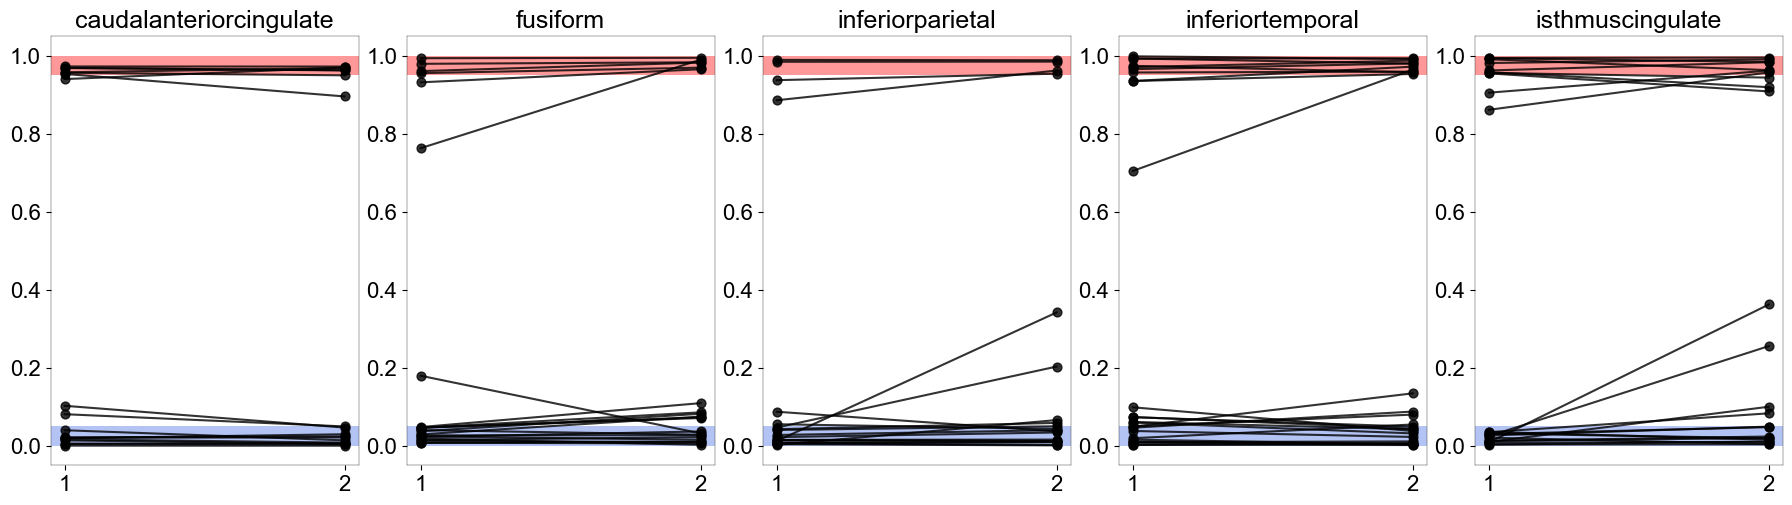

In [18]:
# filter for preterm
abcd_sa_pt = abcd_sa[abcd_sa['dx'] == 'preterm']
abcd_sa_pt.reset_index(inplace=True)
abcd_sa_pt.rename(columns={'session': 'timepoint'}, inplace=True)


# show a reduced amount of rois in the main part
plot_longitudinal_data_subplots(abcd_sa_pt, rois_main, 'SA', out_dir, filter_extranormal=True, num_plots=len(rois_main),dataset='ABCD')

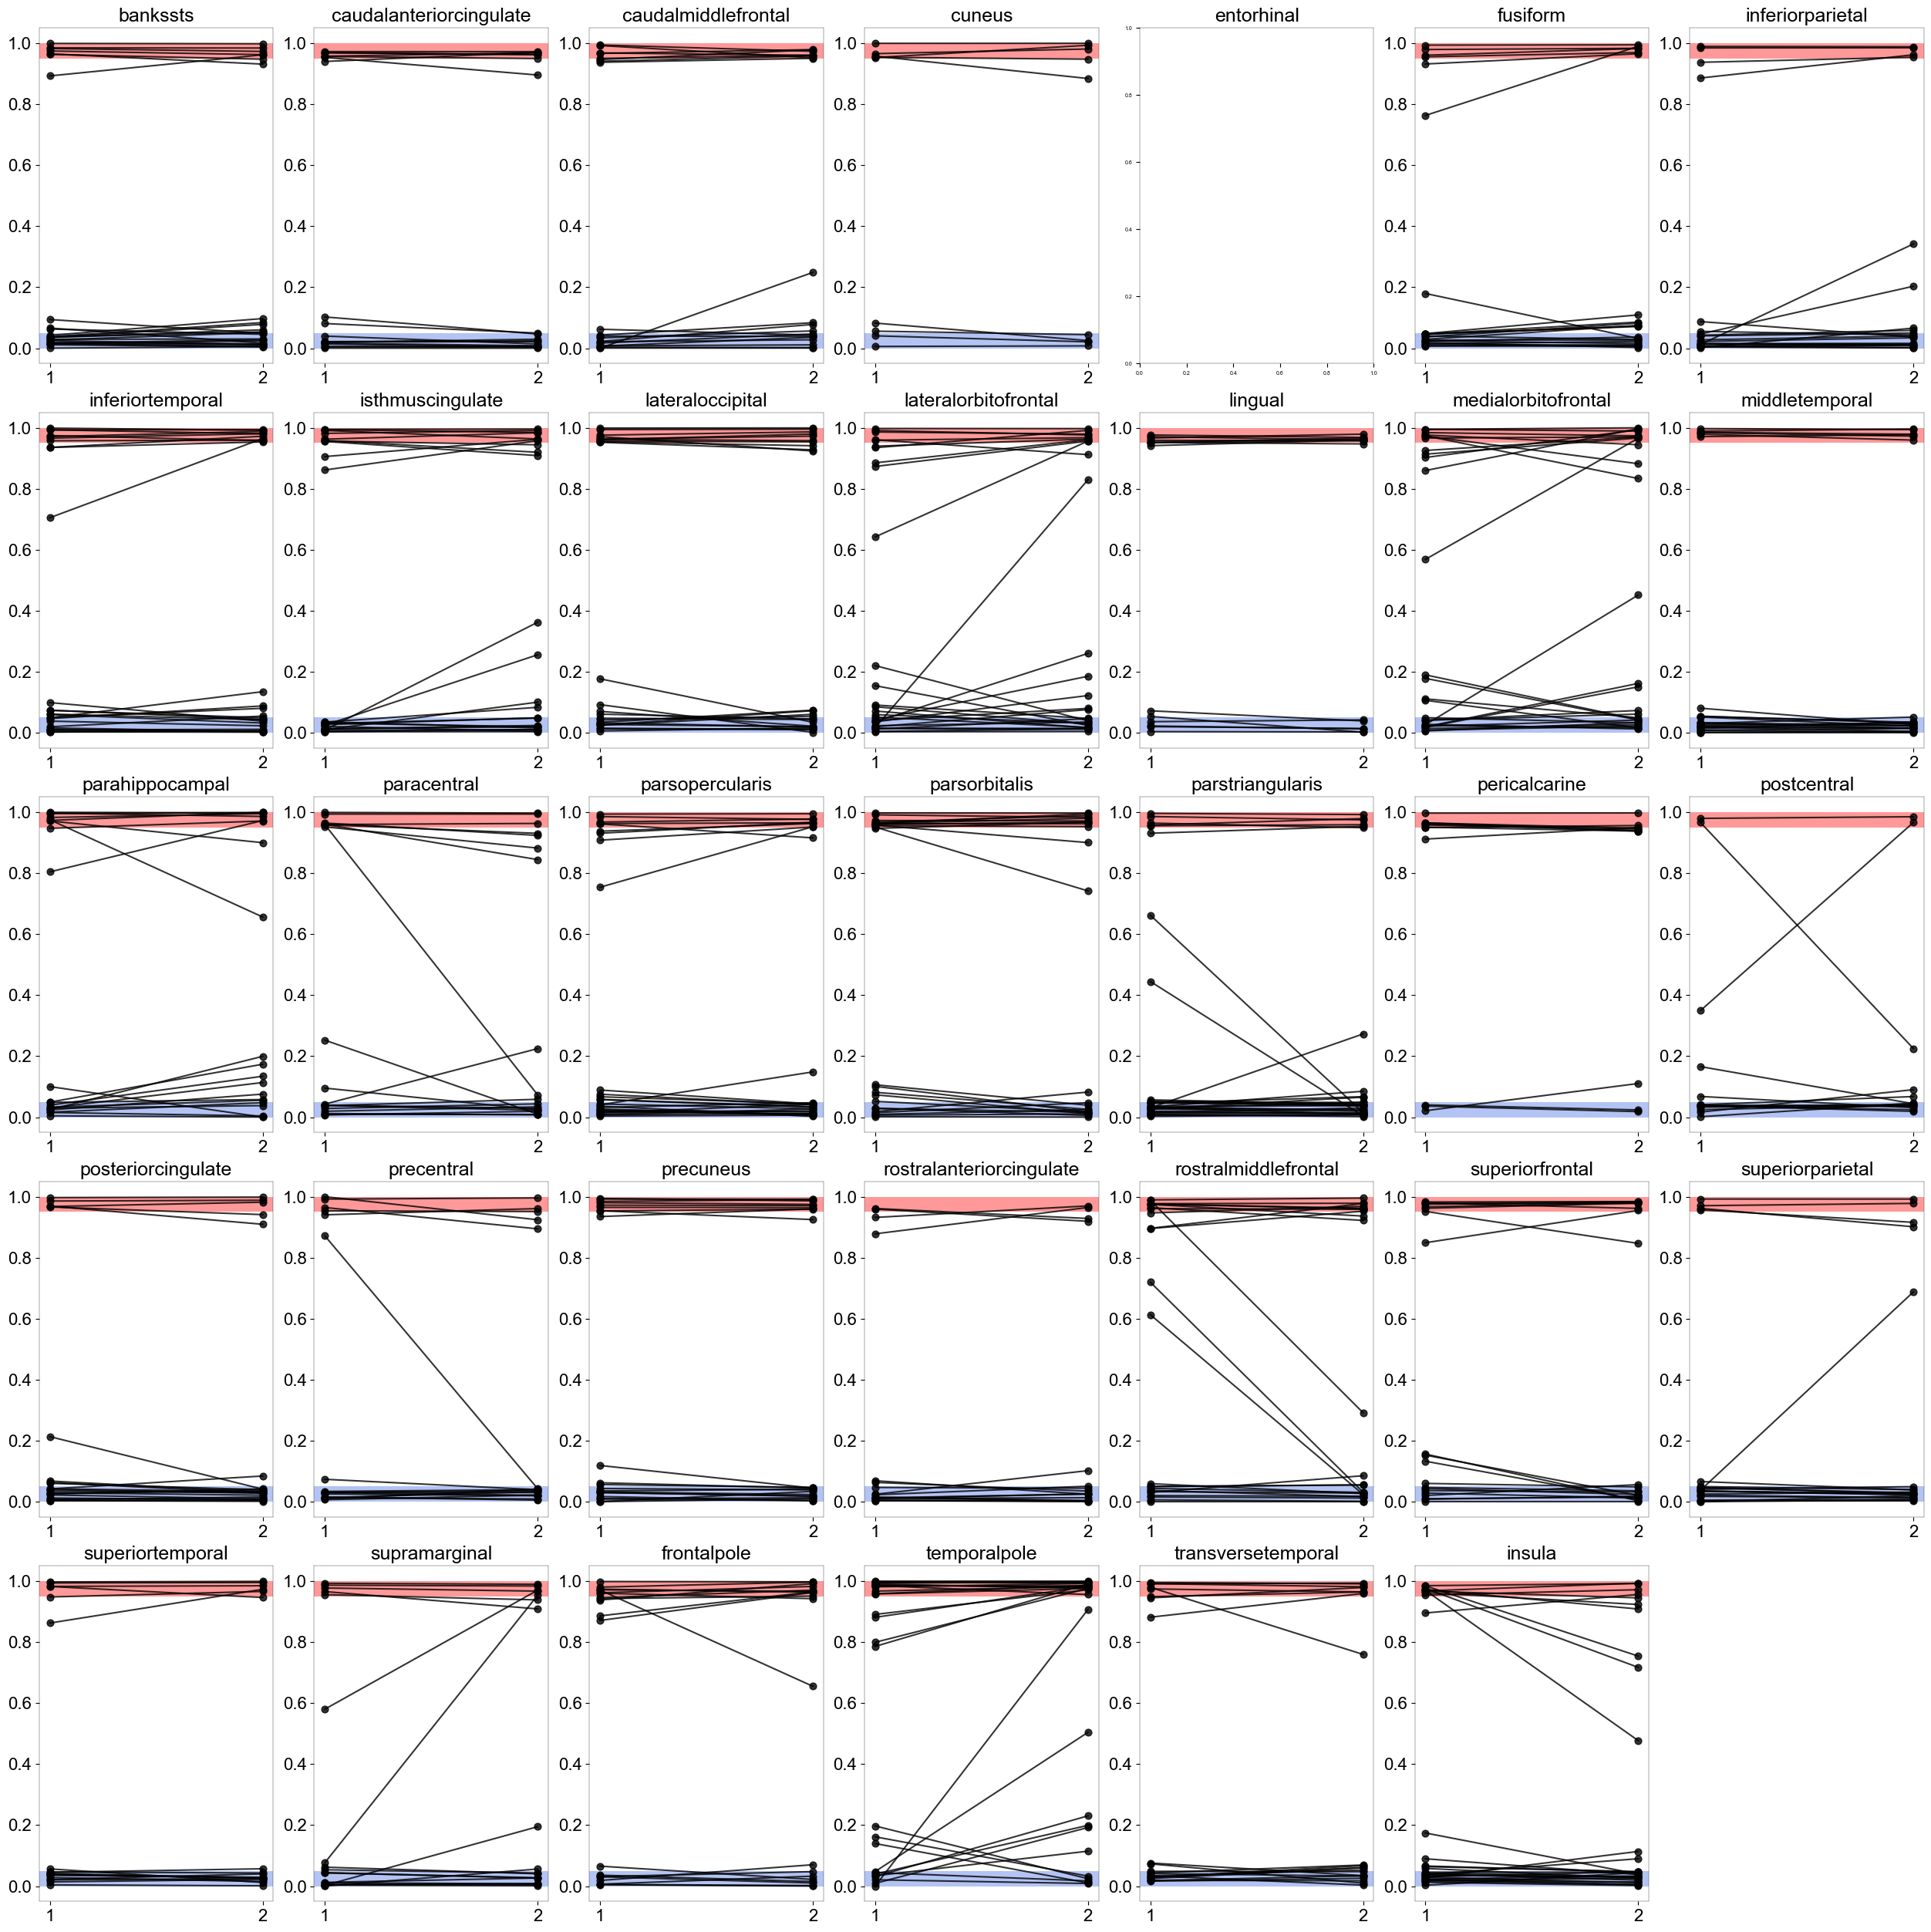

In [19]:
plot_longitudinal_data_subplots(abcd_sa_pt, rois_cortical_centiles, 'SA', out_dir, filter_extranormal=True, dataset='ABCD')

TODO: check what the problem with ICC is - I am not sure if the ICC I selected is the right one

In [20]:
outname = join(out_dir, 'ABCD_SA_longitudinal_ICC.csv')
abcd_icc = compute_longitudinal_icc(abcd_sa_pt, rois_cortical_centiles, outname)
abcd_icc.sort_values('ICC', ascending=False)

ICC        pvalue         p_fdr
centile_SA_superiorfrontal           0.972036  1.070907e-94  3.533994e-93
centile_SA_lingual                   0.969964  1.899432e-92  3.134063e-91
centile_SA_lateraloccipital          0.969066  1.603315e-91  1.763647e-90
centile_SA_caudalmiddlefrontal       0.968872  2.523736e-91  2.082082e-90
centile_SA_posteriorcingulate        0.967308  8.737880e-90  5.767001e-89
centile_SA_precuneus                 0.966614  3.996475e-89  2.198061e-88
centile_SA_inferiorparietal          0.965985  1.538706e-88  7.253901e-88
centile_SA_inferiortemporal          0.964371  4.377725e-87  1.805811e-86
centile_SA_cuneus                    0.961992  4.642626e-85  1.702296e-84
centile_SA_superiortemporal          0.958687  1.890385e-82  6.238269e-82
centile_SA_fusiform                  0.958192  4.450053e-82  1.335016e-81
centile_SA_middletemporal            0.956672  5.815770e-81  1.599337e-80
centile_SA_pericalcarine             0.952839  2.568801e-78  6.520803e-78
centile_SA_bankssts                  0.951015  3.904217e-77  9.202797e-77
centile_SA_isthmuscingulate          0.945076  1.412709e-73  3.107960e-73
centile_SA_superiorparietal          0.944949  1.666753e-73  3.437679e-73
centile_SA_parstriangularis          0.944752  2.151954e-73  4.177323e-73
centile_SA_parsopercularis           0.943249  1.463797e-72  2.683628e-72
centile_SA_caudalanteriorcingulate   0.942988  2.030373e-72  3.460345e-72
centile_SA_supramarginal             0.942962  2.097179e-72  3.460345e-72
centile_SA_parsorbitalis             0.925706  3.034355e-64  4.768272e-64
centile_SA_transversetemporal        0.925212  4.848329e-64  7.272494e-64
centile_SA_rostralmiddlefrontal      0.915845  2.000497e-60  2.870279e-60
centile_SA_paracentral               0.913610  1.263291e-59  1.737025e-59
centile_SA_postcentral               0.913538  1.339702e-59  1.768406e-59
centile_SA_precentral                0.912207  3.917937e-59  4.972766e-59
centile_SA_rostralanteriorcingulate  0.892620  5.037342e-53  6.156752e-53
centile_SA_parahippocampal           0.882121  3.215288e-50  3.789447e-50
centile_SA_lateralorbitofrontal      0.865750  2.441169e-46  2.777882e-46
centile_SA_medialorbitofrontal       0.859610  5.163071e-45  5.679378e-45
centile_SA_insula                    0.836816  1.359068e-40  1.446750e-40
centile_SA_temporalpole              0.785148  1.071658e-32  1.105147e-32
centile_SA_frontalpole               0.783627  1.694041e-32  1.694041e-32

## Adult development - BLS

In [21]:
# add timepoint column
bls_26_sa['timepoint'] = 1
bls_38_sa['timepoint'] = 2

# select only preterm participants with longitudinal data
bls_26_sa_pt = bls_26_sa[bls_26_sa['dx'] == 'preterm']
bls_38_sa_pt = bls_38_sa[bls_38_sa['dx'] == 'preterm']
common_pt_participants = bls_26_sa_pt.merge(bls_38_sa_pt, on='participant', how='inner').index.to_list()
print("Common preterm participants BLS-26 and BLS-38:", len(common_pt_participants))

# filter for common participants
bls_26_sa_common = bls_26_sa.loc[common_pt_participants]
bls_38_sa_common = bls_38_sa.loc[common_pt_participants]

# concat dfs
bls_sa_pt = pd.concat([bls_26_sa_common, bls_38_sa_common], axis=0)
bls_sa_pt.sort_values(by='participant', inplace=True)
bls_sa_pt.reset_index(inplace=True)

Common preterm participants BLS-26 and BLS-38: 46


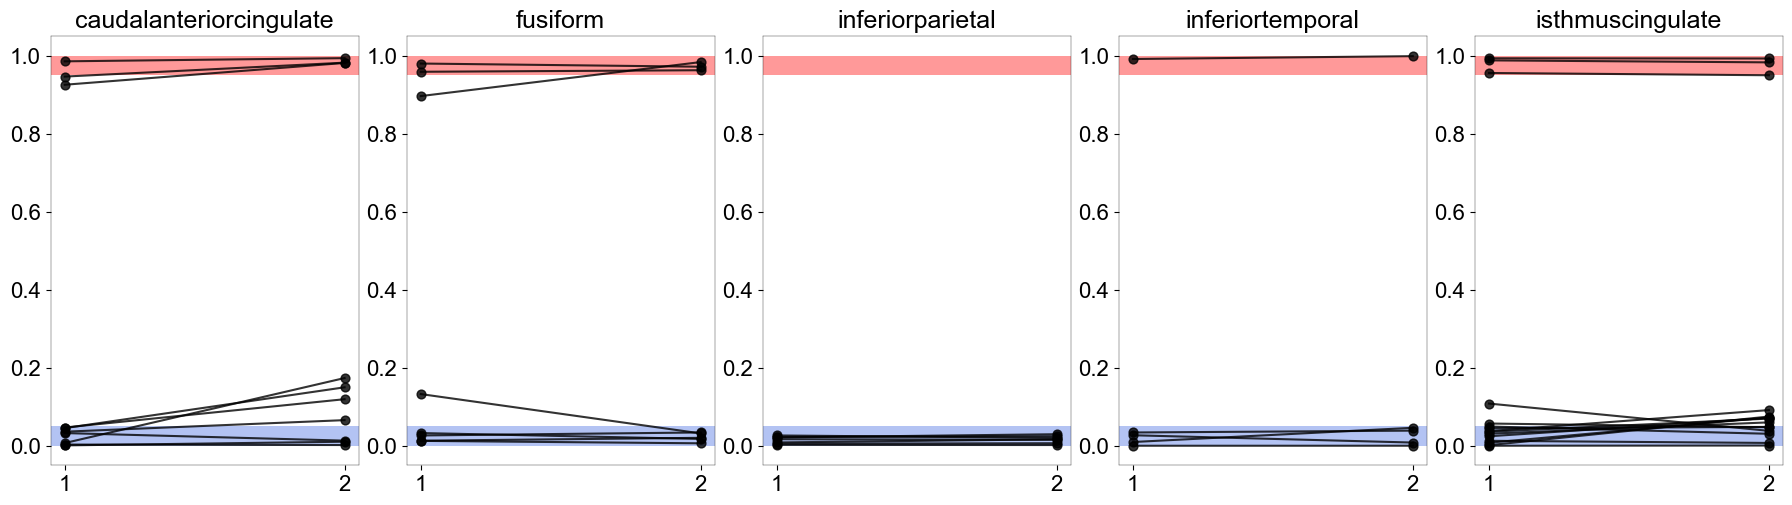

In [22]:
# show a reduced amount of ROIs in the main part
plot_longitudinal_data_subplots(bls_sa_pt, rois_main, 'SA', out_dir, filter_extranormal=True, num_plots=len(rois_main))

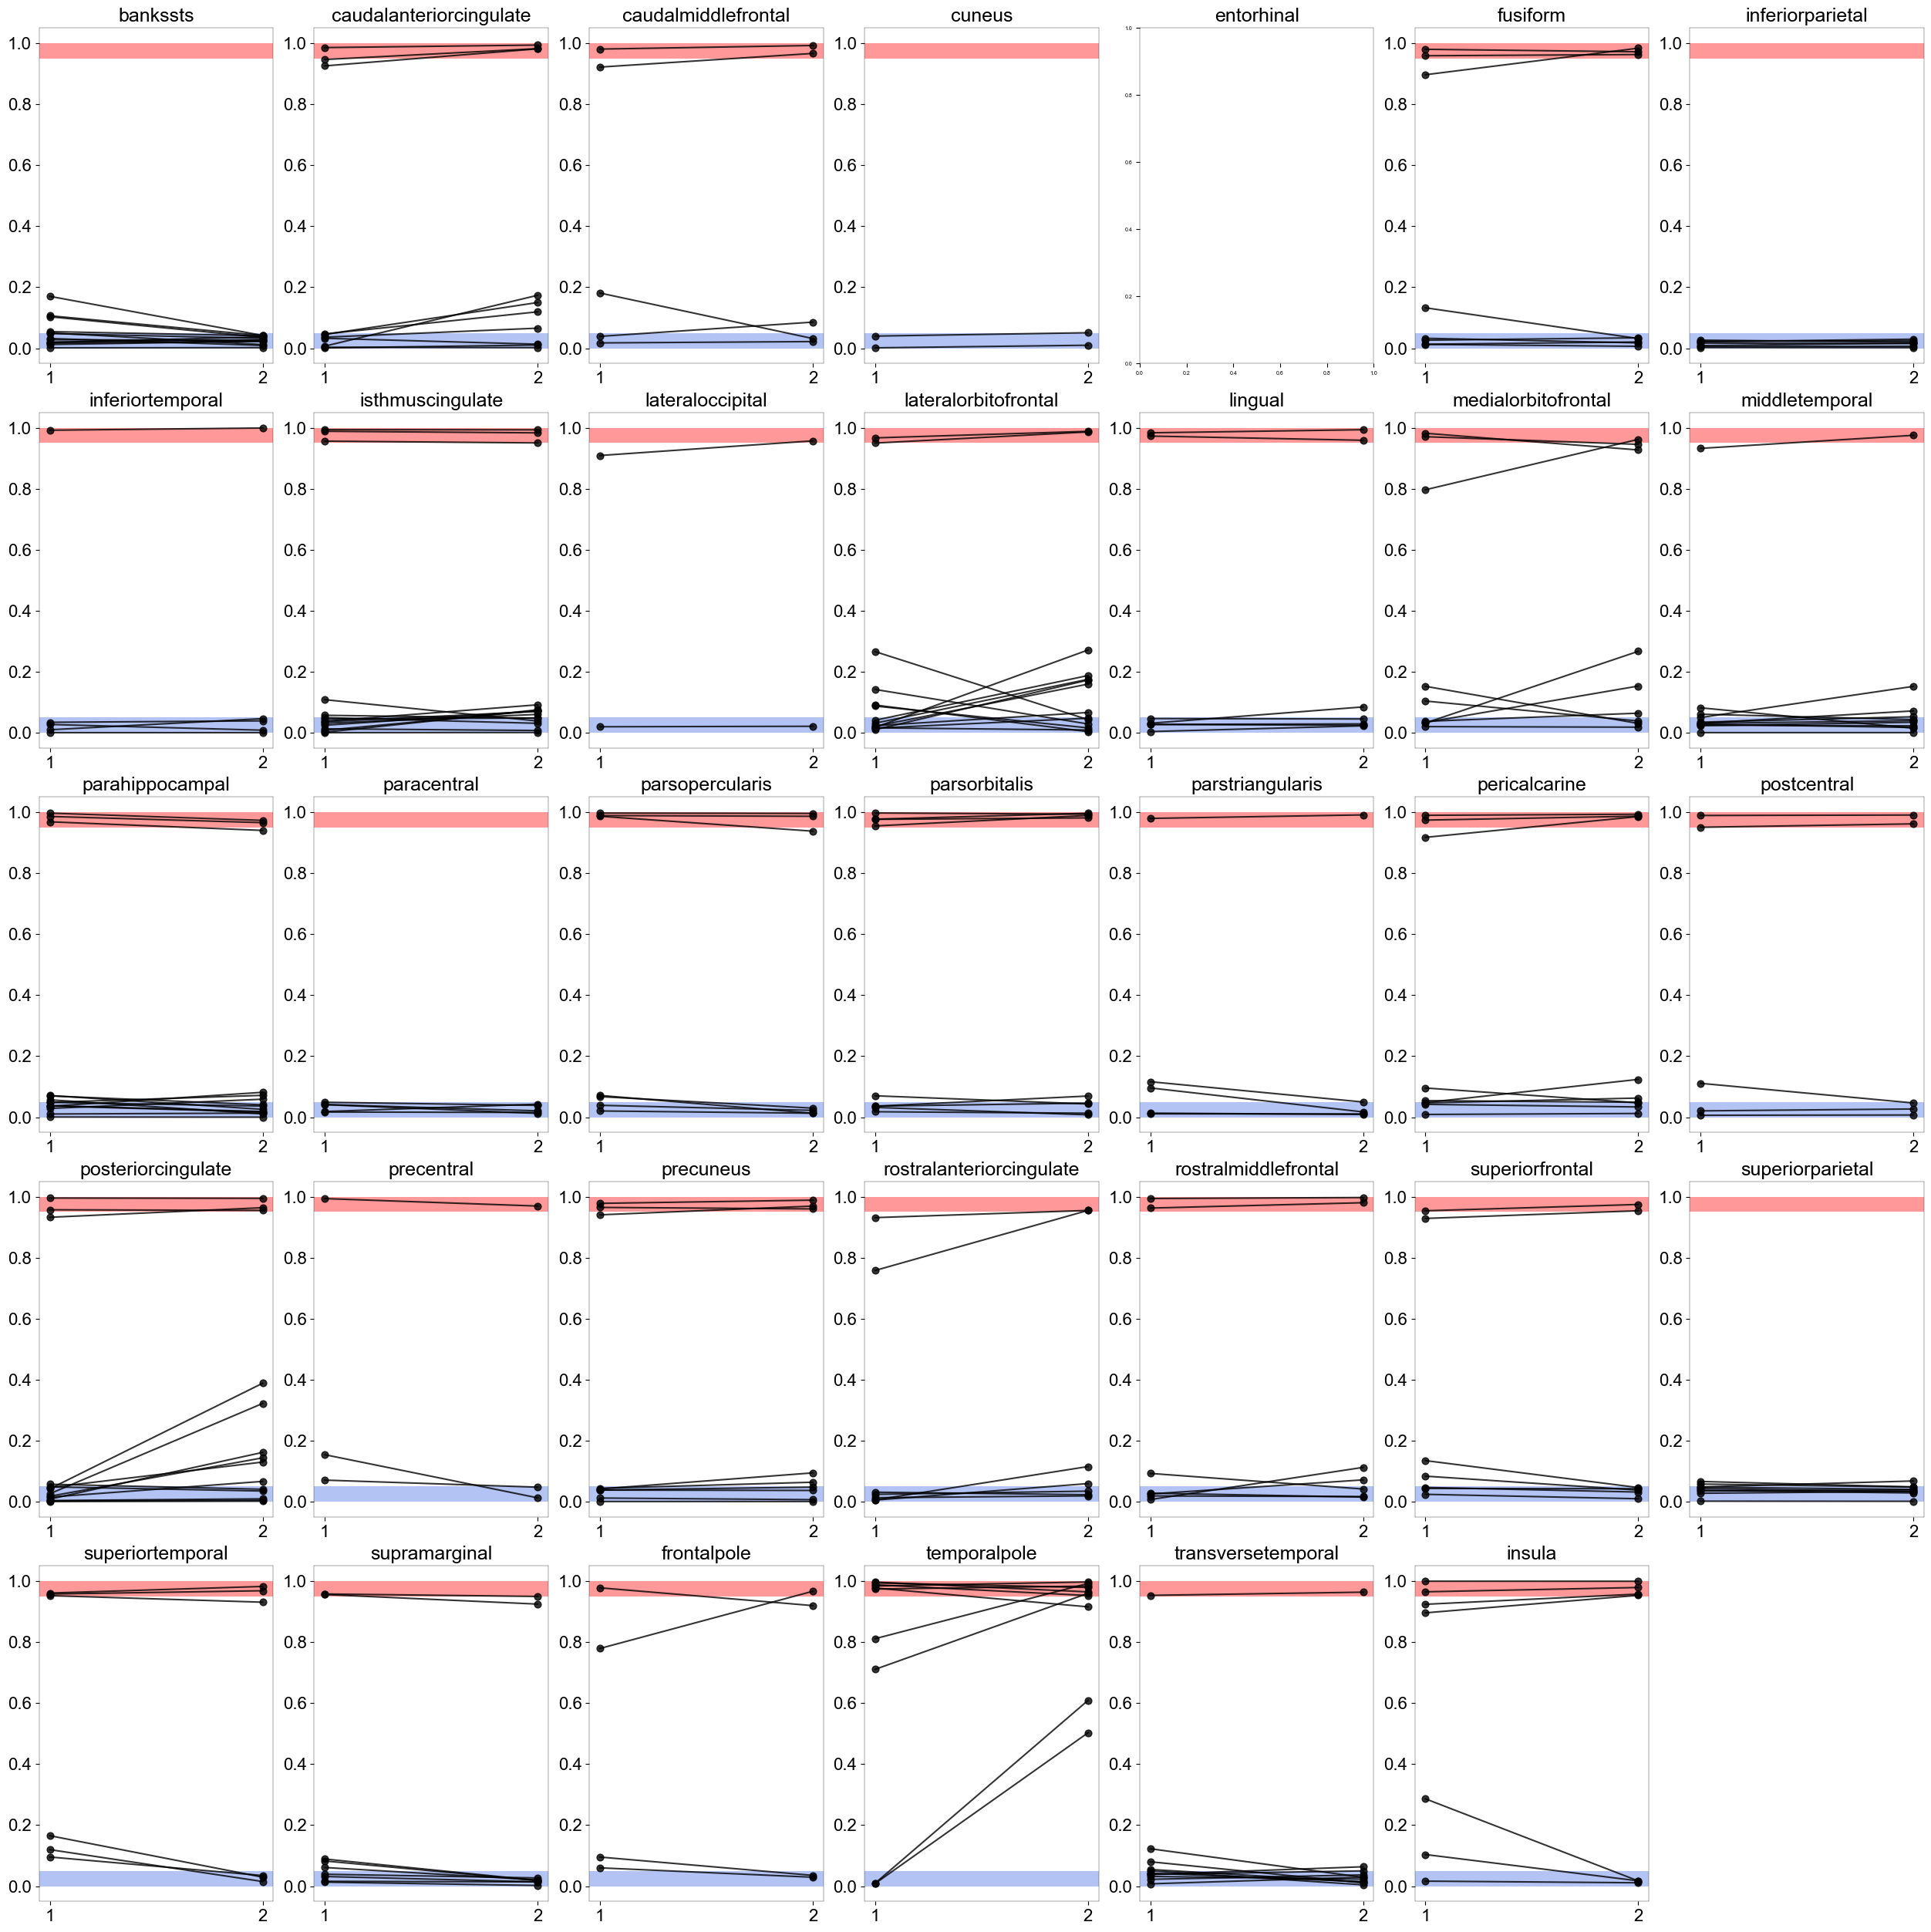

In [23]:
# show all ROIs in supplement
plot_longitudinal_data_subplots(bls_sa_pt, rois_cortical_centiles, 'SA', out_dir, filter_extranormal=True, dataset='BLS')

In [24]:
outname = join(out_dir, 'BLS_SA_longitudinal_ICC.csv')
bls_icc = compute_longitudinal_icc(bls_sa_pt, rois_cortical_centiles, outname)
bls_icc.sort_values('ICC', ascending=False)

ICC        pvalue         p_fdr
centile_SA_superiorparietal          0.989118  2.100250e-39  6.930824e-38
centile_SA_precuneus                 0.982741  6.317532e-35  1.042393e-33
centile_SA_inferiorparietal          0.967994  5.868915e-29  6.455806e-28
centile_SA_parsopercularis           0.967064  1.107526e-28  9.137087e-28
centile_SA_superiorfrontal           0.966175  1.997324e-28  1.318234e-27
centile_SA_supramarginal             0.953179  2.620891e-25  1.441490e-24
centile_SA_lingual                   0.950361  9.477455e-25  3.955522e-24
centile_SA_parstriangularis          0.950282  9.810885e-25  3.955522e-24
centile_SA_caudalanteriorcingulate   0.950067  1.078779e-24  3.955522e-24
centile_SA_pericalcarine             0.947945  2.691552e-24  8.882122e-24
centile_SA_cuneus                    0.944152  1.258576e-23  3.775728e-23
centile_SA_lateraloccipital          0.942000  2.880094e-23  7.920259e-23
centile_SA_posteriorcingulate        0.940237  5.544500e-23  1.407450e-22
centile_SA_caudalmiddlefrontal       0.938884  9.044348e-23  2.131882e-22
centile_SA_paracentral               0.937822  1.317785e-22  2.899126e-22
centile_SA_postcentral               0.935934  2.532150e-22  5.222559e-22
centile_SA_superiortemporal          0.929861  1.821636e-21  3.536118e-21
centile_SA_parsorbitalis             0.924242  9.717002e-21  1.781450e-20
centile_SA_rostralmiddlefrontal      0.918709  4.474147e-20  7.770887e-20
centile_SA_parahippocampal           0.913327  1.786689e-19  2.948037e-19
centile_SA_inferiortemporal          0.906029  1.018565e-18  1.600601e-18
centile_SA_fusiform                  0.905275  1.209382e-18  1.814073e-18
centile_SA_transversetemporal        0.903827  1.675066e-18  2.403355e-18
centile_SA_middletemporal            0.900609  3.393064e-18  4.665463e-18
centile_SA_isthmuscingulate          0.887454  4.824016e-17  6.367701e-17
centile_SA_precentral                0.883146  1.071816e-16  1.343951e-16
centile_SA_bankssts                  0.883006  1.099596e-16  1.343951e-16
centile_SA_lateralorbitofrontal      0.874615  4.767611e-16  5.618970e-16
centile_SA_rostralanteriorcingulate  0.868652  1.270582e-15  1.445834e-15
centile_SA_medialorbitofrontal       0.836055  1.299855e-13  1.429841e-13
centile_SA_insula                    0.802744  5.741986e-12  6.112437e-12
centile_SA_frontalpole               0.663924  1.815823e-07  1.872567e-07
centile_SA_temporalpole              0.646577  4.559670e-07  4.559670e-07

## Supplementary analysis


In [25]:
out_dir_supp = join(outputs_dir, 'location', 'supplement')
os.makedirs(out_dir_supp, exist_ok=True)

rois_cortical = get_roi_names('CT', bilateral=True, global_vars=False)
rois_cortical_centiles = ['centile_' + roi for roi in rois_cortical]

### Child development - ABCD - CTh

/var/folders/tk/3rqd03yd6rqb4_przznzwzjc0000gn/T/ipykernel_63492/3712890.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abcd_ct_pt.rename(columns={'session': 'timepoint'}, inplace=True)


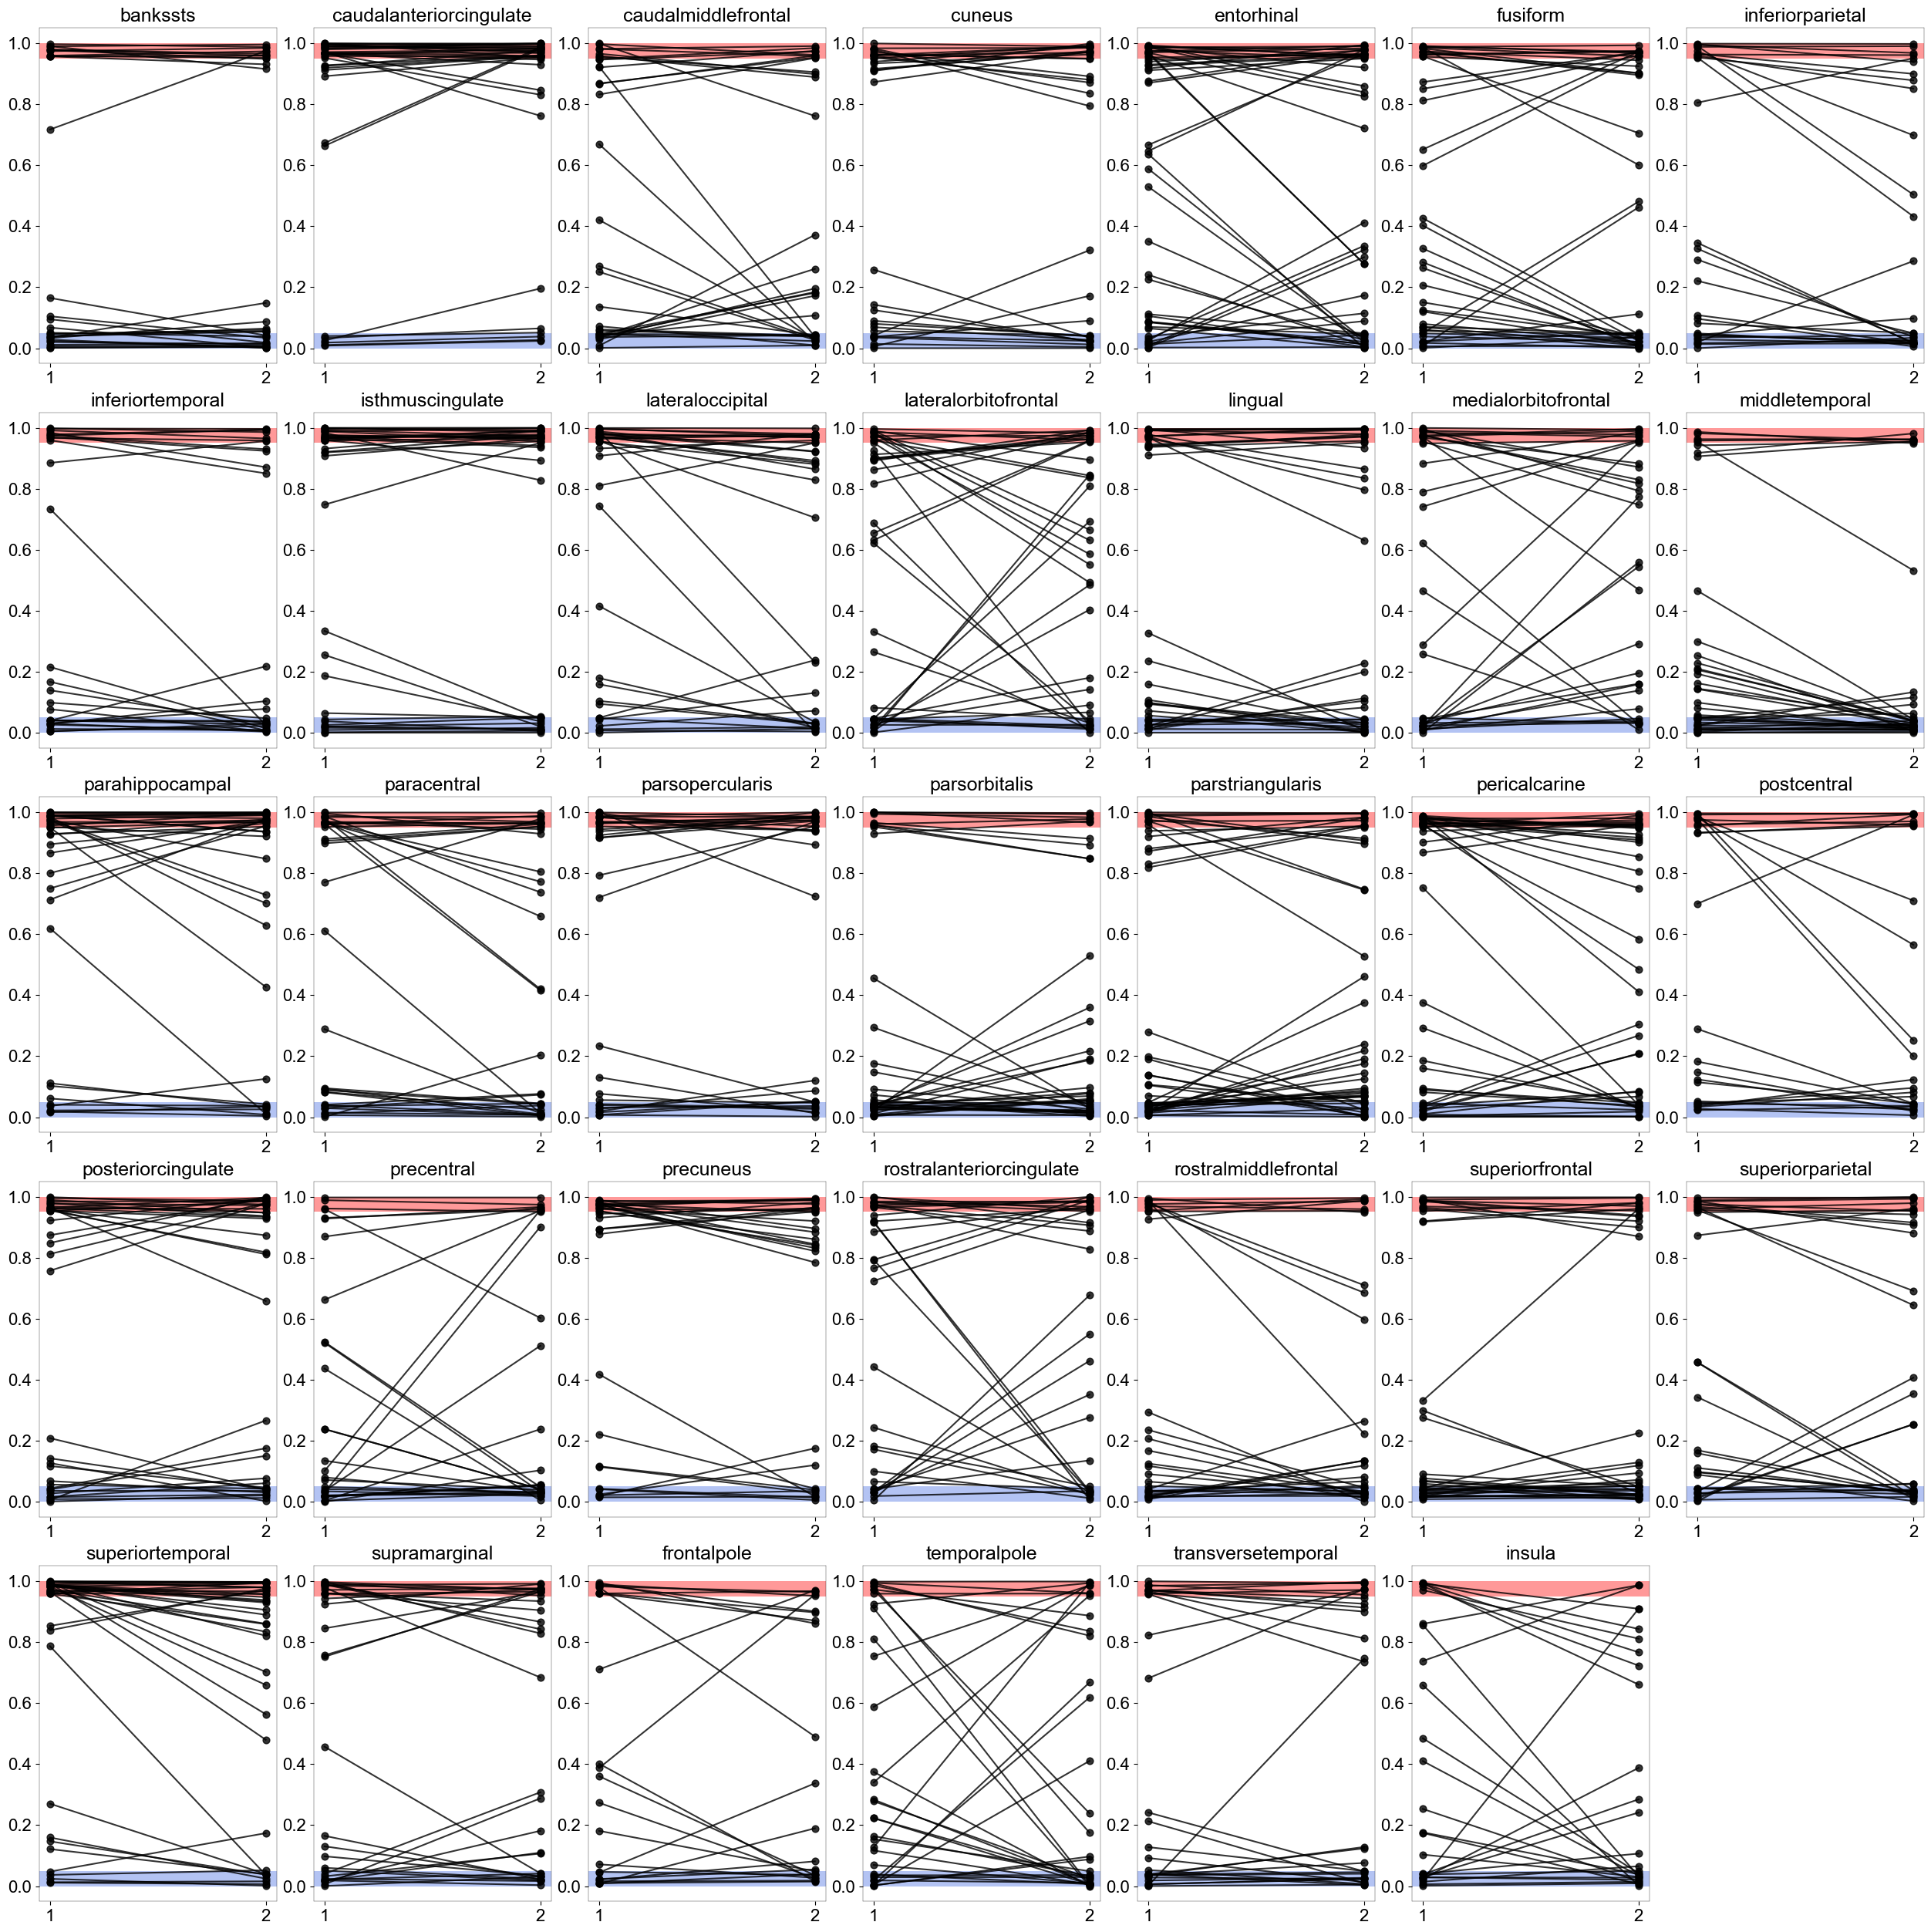

In [26]:
# filter for preterm
abcd_ct_pt = abcd_ct[abcd_ct['dx'] == 'preterm']
abcd_ct_pt.reset_index(inplace=True)
abcd_ct_pt.rename(columns={'session': 'timepoint'}, inplace=True)

plot_longitudinal_data_subplots(abcd_ct_pt, rois_cortical_centiles, 'CT', out_dir_supp, filter_extranormal=True, dataset='ABCD')

In [27]:
outname = join(out_dir_supp, 'ABCD_CT_longitudinal_ICC.csv')
abcd_icc = compute_longitudinal_icc(abcd_ct_pt, rois_cortical_centiles, outname)
abcd_icc.sort_values(by='ICC', ascending=False)

ICC        pvalue         p_fdr
centile_CT_isthmuscingulate          0.876461  1.608163e-62  5.467753e-61
centile_CT_bankssts                  0.873888  1.003100e-61  1.705269e-60
centile_CT_parahippocampal           0.830446  1.852620e-50  2.099636e-49
centile_CT_posteriorcingulate        0.810393  2.727571e-46  2.318435e-45
centile_CT_caudalanteriorcingulate   0.808158  7.403588e-46  5.034440e-45
centile_CT_lateraloccipital          0.801042  1.633948e-44  9.259039e-44
centile_CT_cuneus                    0.798056  5.767139e-44  2.801182e-43
centile_CT_postcentral               0.794296  2.739855e-43  1.164438e-42
centile_CT_lingual                   0.783550  1.979614e-41  7.478540e-41
centile_CT_precuneus                 0.782205  3.325247e-41  1.130584e-40
centile_CT_middletemporal            0.781772  3.926038e-41  1.213503e-40
centile_CT_inferiorparietal          0.778572  1.324559e-40  3.752917e-40
centile_CT_paracentral               0.773987  7.306713e-40  1.910986e-39
centile_CT_parstriangularis          0.769578  3.635108e-39  8.828118e-39
centile_CT_parsopercularis           0.769040  4.411308e-39  9.998965e-39
centile_CT_superiortemporal          0.767386  7.966861e-39  1.692958e-38
centile_CT_supramarginal             0.753007  1.114293e-36  2.228586e-36
centile_CT_inferiortemporal          0.748768  4.483345e-36  8.121682e-36
centile_CT_pericalcarine             0.748730  4.538587e-36  8.121682e-36
centile_CT_superiorfrontal           0.748436  4.992576e-36  8.487379e-36
centile_CT_fusiform                  0.748131  5.513022e-36  8.925845e-36
centile_CT_caudalmiddlefrontal       0.735328  3.098035e-34  4.787872e-34
centile_CT_superiorparietal          0.731126  1.104991e-33  1.633466e-33
centile_CT_precentral                0.704520  2.056633e-30  2.913564e-30
centile_CT_parsorbitalis             0.692016  5.334080e-29  7.254348e-29
centile_CT_frontalpole               0.688520  1.286739e-28  1.682658e-28
centile_CT_transversetemporal        0.662702  5.963806e-26  7.509977e-26
centile_CT_rostralmiddlefrontal      0.660941  8.866161e-26  1.076605e-25
centile_CT_entorhinal                0.632761  3.582482e-23  4.200151e-23
centile_CT_lateralorbitofrontal      0.605949  6.261584e-21  7.096462e-21
centile_CT_medialorbitofrontal       0.604656  7.935204e-21  8.703127e-21
centile_CT_rostralanteriorcingulate  0.582141  4.146978e-19  4.406165e-19
centile_CT_temporalpole              0.444288  5.399599e-11  5.563223e-11
centile_CT_insula                    0.393766  7.998907e-09  7.998907e-09

### Adult development - BLS - CTh

In [28]:
# adjust df structure
bls_26_ct.reset_index(inplace=True)
bls_26_ct.set_index(['participant', 'session'], inplace=True)

Common preterm participants BLS-26 and BLS-38: 46


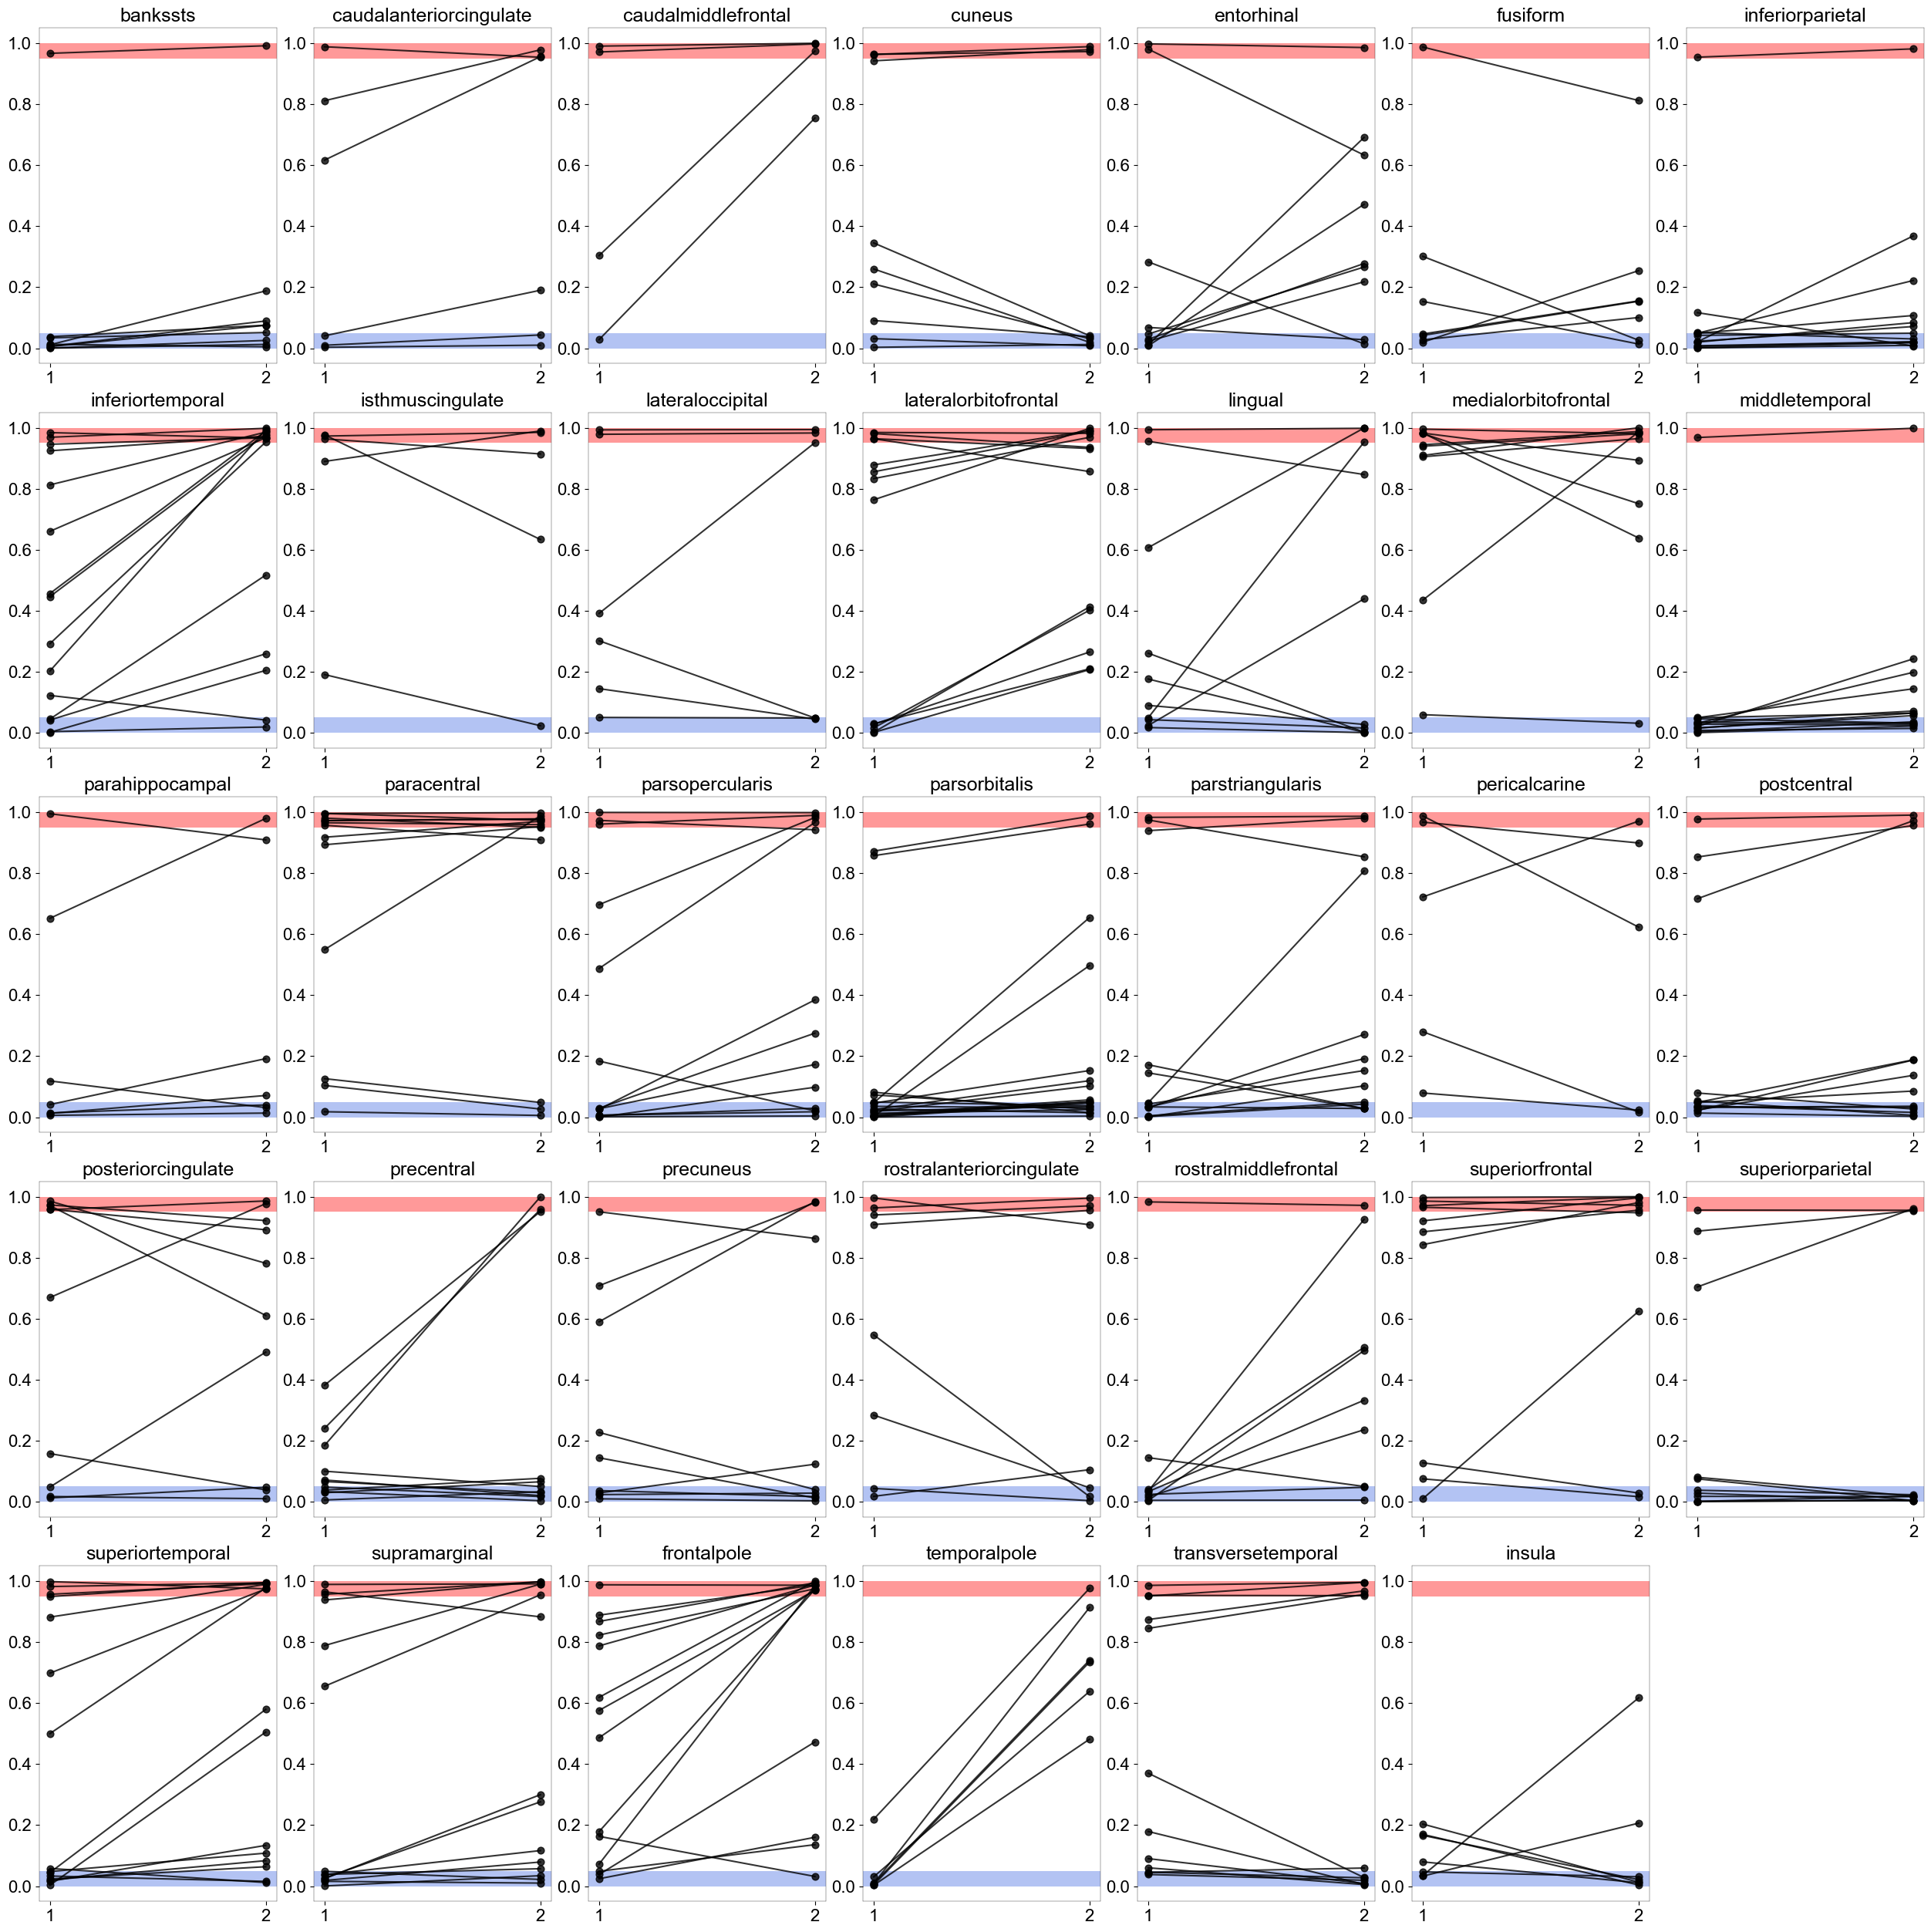

In [29]:
# add timepoint column
bls_26_ct['timepoint'] = 1
bls_38_ct['timepoint'] = 2

# select only preterm participants with longitudinal data
bls_26_ct_pt = bls_26_ct[bls_26_ct['dx'] == 'preterm']
bls_38_ct_pt = bls_38_ct[bls_38_ct['dx'] == 'preterm']
common_pt_participants = bls_26_ct_pt.merge(bls_38_ct_pt, on='participant', how='inner').index.to_list()
print("Common preterm participants BLS-26 and BLS-38:", len(common_pt_participants))

# filter for common participants
bls_26_ct_common = bls_26_ct.loc[common_pt_participants]
bls_38_ct_common = bls_38_ct.loc[common_pt_participants]

# concat dfs
bls_ct_pt = pd.concat([bls_26_ct_common, bls_38_ct_common], axis=0)
bls_ct_pt.sort_values(by='participant', inplace=True)
bls_ct_pt.reset_index(inplace=True)


plot_longitudinal_data_subplots(bls_ct_pt, rois_cortical_centiles, 'CT', out_dir_supp, filter_extranormal=True, dataset='BLS')

In [30]:
outname = join(out_dir_supp, 'BLS_CT_longitudinal_ICC.csv')
bls_icc = compute_longitudinal_icc(bls_ct_pt, rois_cortical_centiles, outname)
bls_icc.sort_values(by='ICC', ascending=False)

ICC        pvalue         p_fdr
centile_CT_supramarginal             0.844032  4.623269e-14  1.571911e-12
centile_CT_postcentral               0.812613  2.022467e-12  2.826944e-11
centile_CT_precuneus                 0.810411  2.566030e-12  2.826944e-11
centile_CT_parsorbitalis             0.807979  3.325817e-12  2.826944e-11
centile_CT_paracentral               0.803923  5.084828e-12  3.457683e-11
centile_CT_superiorparietal          0.798992  8.408754e-12  4.764960e-11
centile_CT_inferiorparietal          0.796876  1.038962e-11  5.046388e-11
centile_CT_bankssts                  0.795032  1.246922e-11  5.299417e-11
centile_CT_superiorfrontal           0.779080  5.613066e-11  2.120491e-10
centile_CT_cuneus                    0.774819  8.215873e-11  2.793397e-10
centile_CT_parsopercularis           0.766143  1.740805e-10  5.380669e-10
centile_CT_parahippocampal           0.758743  3.221569e-10  9.127778e-10
centile_CT_caudalanteriorcingulate   0.736065  1.868005e-09  4.885552e-09
centile_CT_transversetemporal        0.719603  6.006278e-09  1.457021e-08
centile_CT_rostralanteriorcingulate  0.718609  6.428035e-09  1.457021e-08
centile_CT_superiortemporal          0.708649  1.249654e-08  2.655516e-08
centile_CT_caudalmiddlefrontal       0.705380  1.545036e-08  3.090072e-08
centile_CT_posteriorcingulate        0.686690  4.931996e-08  9.315993e-08
centile_CT_precentral                0.672228  1.143646e-07  2.046525e-07
centile_CT_parstriangularis          0.667152  1.519742e-07  2.583562e-07
centile_CT_lateraloccipital          0.638369  6.910391e-07  1.118825e-06
centile_CT_inferiortemporal          0.618640  1.788695e-06  2.764347e-06
centile_CT_middletemporal            0.590596  6.212421e-06  9.183579e-06
centile_CT_rostralmiddlefrontal      0.567665  1.582179e-05  2.241420e-05
centile_CT_lingual                   0.560934  2.054863e-05  2.794614e-05
centile_CT_isthmuscingulate          0.558045  2.294817e-05  3.000915e-05
centile_CT_frontalpole               0.548343  3.301040e-05  4.156866e-05
centile_CT_insula                    0.545369  3.682003e-05  4.471003e-05
centile_CT_lateralorbitofrontal      0.539272  4.591255e-05  5.382851e-05
centile_CT_medialorbitofrontal       0.538041  4.798050e-05  5.437790e-05
centile_CT_pericalcarine             0.519533  9.119180e-05  1.000168e-04
centile_CT_entorhinal                0.484309  2.808982e-04  2.984544e-04
centile_CT_fusiform                  0.426488  1.397950e-03  1.440312e-03
centile_CT_temporalpole             -0.093047  7.330530e-01  7.330530e-01